In [1]:
from pynq import Overlay
from pynq import allocate
import numpy as np

# Adjust path to your bitstream here
overlay = Overlay("/home/xilinx/jupyter_notebooks/design_1_wrapper.xsa")



In [2]:
help(overlay)

Help on Overlay in module pynq.overlay:

<pynq.overlay.Overlay object>
    Default documentation for overlay /home/xilinx/jupyter_notebooks/design_1_wrapper.xsa. The following
    attributes are available on this overlay:
    
    IP Blocks
    ----------
    sr_fft_0             : pynq.overlay.DefaultIP
    processing_system7_0 : pynq.overlay.DefaultIP
    
    Hierarchies
    -----------
    None
    
    Interrupts
    ----------
    None
    
    GPIO Outputs
    ------------
    None
    
    Memories
    ------------
    PSDDR                : Memory



In [3]:
fft_ip = overlay.sr_fft_0

In [4]:
import numpy as np
from pynq import MMIO
from time import sleep

# Base addresses from your info
CTRL_BASEADDR = 0x40000000   # Control registers + memories start here
CTRL_SPACE = 0x1000           # 4KB space to map whole IP (includes control + memories)

mmio = MMIO(CTRL_BASEADDR, CTRL_SPACE)


In [5]:
N = 64
freq_bin = 10
PI = np.pi

# Generate complex input data (complex64)
input_data = np.zeros(N, dtype=np.complex64)

for i in range(N):
    phase = 2 * PI * freq_bin * i / N
    input_data[i] = np.cos(phase) + 1j * np.sin(phase)


In [6]:
def bank_offset_input(bank_num: int) -> int:
    return 0x40 + bank_num * 0x40

def bank_offset_output(bank_num: int) -> int:
    return 0x240 + bank_num * 0x40


In [7]:
def write_complex_bank(mmio: MMIO, bank_num: int, data: np.ndarray):
    assert data.size == 8, "Bank data must be of length 8"
    assert data.dtype == np.complex64, "Data dtype must be complex64"
    offset = bank_offset_input(bank_num)
    # Convert complex64 array to bytes
    bytes_data = data.tobytes()
    # MMIO.data is a bytearray, write 64 bytes one-by-one
    for i in range(len(bytes_data)):
        mmio.write(offset + i, bytes_data[i])


In [8]:
def read_complex_bank(mmio: MMIO, bank_num: int) -> np.ndarray:
    offset = bank_offset_output(bank_num)
    # Read 64 bytes from MMIO memory bank
    banks_bytes = bytearray(64)
    for i in range(64):
        banks_bytes[i] = mmio.read(offset + i) & 0xFF
    # Convert to complex64 array
    return np.frombuffer(banks_bytes, dtype=np.complex64)


In [9]:
def start_fft():
    """Start the FFT computation by setting ap_start bit"""
    ctrl_reg = mmio.read(AP_CTRL_OFFSET)
    mmio.write(AP_CTRL_OFFSET, ctrl_reg | 0x01)
    print("FFT started")

def is_fft_done():
    """Check if FFT computation is complete by reading ap_done bit"""
    ctrl_reg = mmio.read(AP_CTRL_OFFSET)
    return (ctrl_reg >> 1) & 0x01

def wait_for_completion(timeout_sec=2.0):
    """Wait for FFT to complete with timeout"""
    start_time = time.time()
    while not is_fft_done():
        if time.time() - start_time > timeout_sec:
            raise TimeoutError("FFT computation timed out")
        time.sleep(0.001)  # 1ms polling interval
    print("FFT computation completed")

def reset_ip():
    """Reset the IP by clearing control register"""
    mmio.write(AP_CTRL_OFFSET, 0x00)
    print("IP reset")


In [10]:
def write_complex_bank(bank_num, complex_data):
    """Write 8 complex64 samples to specified input bank"""
    if bank_num < 0 or bank_num >= NUM_BANKS:
        raise ValueError(f"Bank number must be 0-{NUM_BANKS-1}")
    
    if len(complex_data) != SAMPLES_PER_BANK:
        raise ValueError(f"Must provide exactly {SAMPLES_PER_BANK} complex samples")
    
    # Convert complex64 array to uint32 view for MMIO writing
    complex_array = np.array(complex_data, dtype=np.complex64)
    uint32_view = complex_array.view(np.uint32)  # 16 uint32 values
    
    # Write to input bank memory
    base_offset = INPUT_OFFSETS[bank_num]
    for i, value in enumerate(uint32_view):
        mmio.write(base_offset + i*4, int(value))
    
    print(f"Written {len(complex_data)} samples to input bank {bank_num}")

def read_complex_bank(bank_num):
    """Read 8 complex64 samples from specified output bank"""
    if bank_num < 0 or bank_num >= NUM_BANKS:
        raise ValueError(f"Bank number must be 0-{NUM_BANKS-1}")
    
    # Read 16 uint32 values (8 complex64 = 16 uint32)
    base_offset = OUTPUT_OFFSETS[bank_num]
    uint32_values = []
    
    for i in range(16):  # 16 uint32 words = 8 complex64 samples
        value = mmio.read(base_offset + i*4)
        uint32_values.append(value)
    
    # Convert uint32 array back to complex64
    uint32_array = np.array(uint32_values, dtype=np.uint32)
    complex_array = uint32_array.view(np.complex64)
    
    return complex_array

def write_all_input_banks(input_data):
    """Write 64 complex samples across all 8 input banks"""
    if len(input_data) != N:
        raise ValueError(f"Input data must have exactly {N} samples")
    
    # Split data into 8 banks of 8 samples each
    input_banks = np.array(input_data).reshape(NUM_BANKS, SAMPLES_PER_BANK)
    
    for bank_num in range(NUM_BANKS):
        write_complex_bank(bank_num, input_banks[bank_num])
    
    print(f"All {N} input samples written to {NUM_BANKS} banks")

def read_all_output_banks():
    """Read 64 complex samples from all 8 output banks"""
    output_data = []
    
    for bank_num in range(NUM_BANKS):
        bank_data = read_complex_bank(bank_num)
        output_data.extend(bank_data)
    
    print(f"All {len(output_data)} output samples read from {NUM_BANKS} banks")
    return np.array(output_data)


In [11]:
def start_fft():
    """Start the FFT computation by setting ap_start bit"""
    ctrl_reg = mmio.read(AP_CTRL_OFFSET)
    mmio.write(AP_CTRL_OFFSET, ctrl_reg | 0x01)
    print("FFT started")

def is_fft_done():
    """Check if FFT computation is complete by reading ap_done bit"""
    ctrl_reg = mmio.read(AP_CTRL_OFFSET)
    return (ctrl_reg >> 1) & 0x01

def is_fft_idle():
    """Check if FFT IP is idle by reading ap_idle bit"""
    ctrl_reg = mmio.read(AP_CTRL_OFFSET)
    return (ctrl_reg >> 2) & 0x01

def wait_for_completion(timeout_sec=2.0):
    """Wait for FFT to complete with timeout"""
    start_time = time.time()
    while not is_fft_done():
        if time.time() - start_time > timeout_sec:
            raise TimeoutError("FFT computation timed out")
        time.sleep(0.001)  # 1ms polling interval
    print("FFT computation completed")

def reset_ip():
    """Reset the IP by clearing control register"""
    mmio.write(AP_CTRL_OFFSET, 0x00)
    print("IP reset")


In [12]:
def write_complex_bank(bank_num, complex_data):
    """
    Write 8 complex64 samples to specified input bank
    Each complex64 = 8 bytes = 2 uint32 words
    Total per bank: 8 samples * 8 bytes = 64 bytes = 16 uint32 words
    """
    if bank_num < 0 or bank_num >= NUM_BANKS:
        raise ValueError(f"Bank number must be 0-{NUM_BANKS-1}")
    
    if len(complex_data) != SAMPLES_PER_BANK:
        raise ValueError(f"Must provide exactly {SAMPLES_PER_BANK} complex samples")
    
    # Convert complex64 array to uint32 view for MMIO writing
    complex_array = np.array(complex_data, dtype=np.complex64)
    uint32_view = complex_array.view(np.uint32)  # 16 uint32 values
    
    # Write to input bank memory
    base_offset = INPUT_OFFSETS[bank_num]
    for i, value in enumerate(uint32_view):
        mmio.write(base_offset + i*4, int(value))
    
    print(f"Written {len(complex_data)} samples to input bank {bank_num}")

def read_complex_bank(bank_num):
    """
    Read 8 complex64 samples from specified output bank
    Returns numpy array of complex64 values
    """
    if bank_num < 0 or bank_num >= NUM_BANKS:
        raise ValueError(f"Bank number must be 0-{NUM_BANKS-1}")
    
    # Read 16 uint32 values (8 complex64 = 16 uint32)
    base_offset = OUTPUT_OFFSETS[bank_num]
    uint32_values = []
    
    for i in range(16):  # 16 uint32 words = 8 complex64 samples
        value = mmio.read(base_offset + i*4)
        uint32_values.append(value)
    
    # Convert uint32 array back to complex64
    uint32_array = np.array(uint32_values, dtype=np.uint32)
    complex_array = uint32_array.view(np.complex64)
    
    print(f"Read {len(complex_array)} samples from output bank {bank_num}")
    return complex_array

def write_all_input_banks(input_data):
    """Write 64 complex samples across all 8 input banks"""
    if len(input_data) != N:
        raise ValueError(f"Input data must have exactly {N} samples")
    
    # Split data into 8 banks of 8 samples each
    input_banks = np.array(input_data).reshape(NUM_BANKS, SAMPLES_PER_BANK)
    
    for bank_num in range(NUM_BANKS):
        write_complex_bank(bank_num, input_banks[bank_num])
    
    print(f"All {N} input samples written to {NUM_BANKS} banks")

def read_all_output_banks():
    """Read 64 complex samples from all 8 output banks"""
    output_data = []
    
    for bank_num in range(NUM_BANKS):
        bank_data = read_complex_bank(bank_num)
        output_data.extend(bank_data)
    
    print(f"All {len(output_data)} output samples read from {NUM_BANKS} banks")
    return np.array(output_data)


Resetting IP...
Generating input signal...
Writing input data to IP...
Starting FFT...
Waiting for FFT to complete...
Reading FFT output...
Calculating numpy FFT...


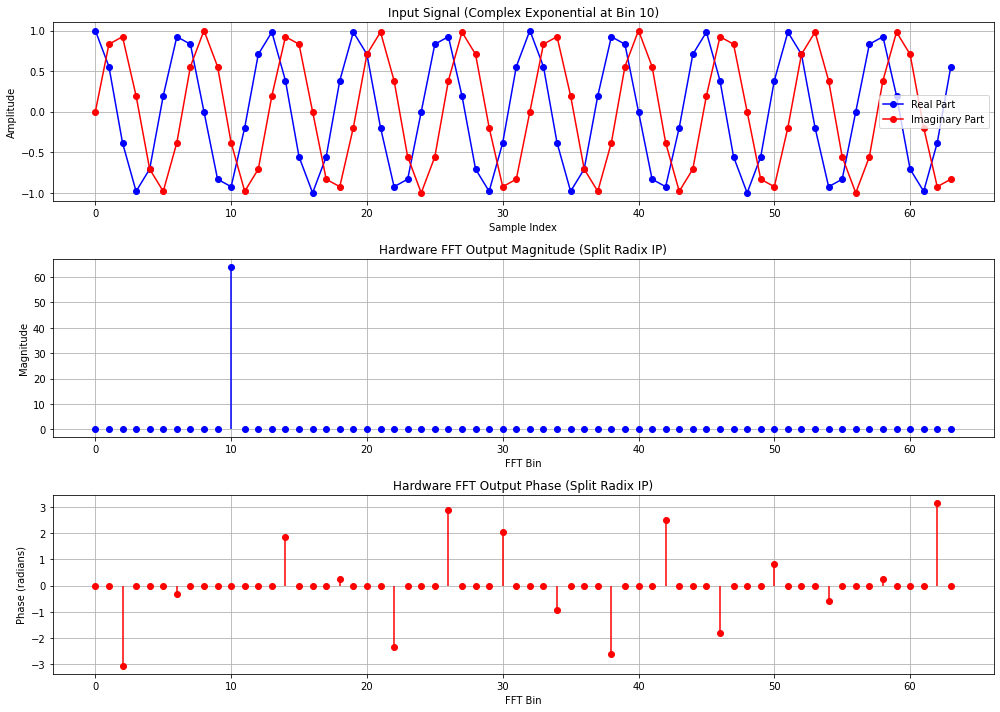

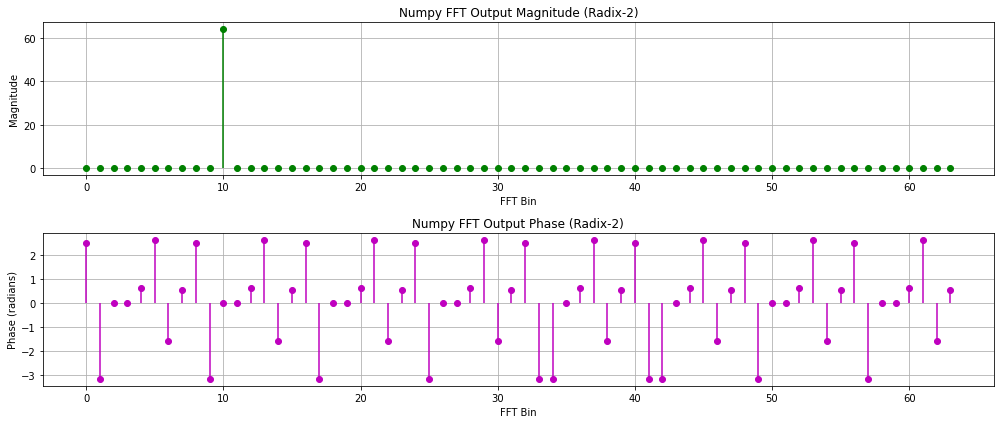

In [13]:
import numpy as np
import time
from pynq import MMIO
import matplotlib.pyplot as plt

CTRL_BASEADDR = 0x40000000
CTRL_SPACE = 0x1000
N = 64
NUM_BANKS = 8
SAMPLES_PER_BANK = 8
FIXED_POINT_FRACTIONAL = 16

INPUT_OFFSETS = [0x040 + 0x40 * i for i in range(NUM_BANKS)]
OUTPUT_OFFSETS = [0x240 + 0x40 * i for i in range(NUM_BANKS)]
AP_CTRL_OFFSET = 0x000

mmio = MMIO(CTRL_BASEADDR, CTRL_SPACE)

def float_to_fixed(flt):
    scaled = int(np.round(flt * (1 << FIXED_POINT_FRACTIONAL)))
    if scaled >= (1 << 31):
        scaled -= (1 << 32)
    elif scaled < -(1 << 31):
        scaled += (1 << 32)
    return np.uint32(scaled & 0xFFFFFFFF)

def fixed_to_float(fx):
    fx &= 0xFFFFFFFF
    if fx & 0x80000000:
        fx_signed = fx - 0x100000000
    else:
        fx_signed = fx
    return fx_signed / float(1 << FIXED_POINT_FRACTIONAL)

def write_complex_bank(bank_num, complex_data):
    if len(complex_data) != SAMPLES_PER_BANK:
        raise ValueError(f"Bank {bank_num} must have exactly {SAMPLES_PER_BANK} samples")
    base = INPUT_OFFSETS[bank_num]
    for i, c in enumerate(complex_data):
        real_fixed = float_to_fixed(np.real(c))
        imag_fixed = float_to_fixed(np.imag(c))
        mmio.write(base + i * 8, int(real_fixed))
        mmio.write(base + i * 8 + 4, int(imag_fixed))

def read_complex_bank(bank_num):
    base = OUTPUT_OFFSETS[bank_num]
    complex_vals = []
    for i in range(SAMPLES_PER_BANK):
        real_fixed = mmio.read(base + i * 8)
        imag_fixed = mmio.read(base + i * 8 + 4)
        real_float = fixed_to_float(real_fixed)
        imag_float = fixed_to_float(imag_fixed)
        complex_vals.append(real_float + 1j * imag_float)
    return np.array(complex_vals, dtype=np.complex64)

def write_all_input_banks(input_data):
    if len(input_data) != N:
        raise ValueError(f"Input data length must be {N}")
    for b in range(NUM_BANKS):
        bank_data = input_data[b*SAMPLES_PER_BANK:(b+1)*SAMPLES_PER_BANK]
        write_complex_bank(b, bank_data)

def read_all_output_banks():
    output_data = []
    for b in range(NUM_BANKS):
        bank_data = read_complex_bank(b)
        output_data.extend(bank_data)
    return np.array(output_data)

def start_fft():
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    mmio.write(AP_CTRL_OFFSET, ctrl_val | 0x1)

def is_fft_done():
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    return ((ctrl_val >> 1) & 0x1) == 1

def wait_for_fft_done(timeout=2.0):
    start_time = time.time()
    while not is_fft_done():
        if time.time() - start_time > timeout:
            raise TimeoutError("FFT did not complete in time")
        time.sleep(0.001)

def reset_ip():
    mmio.write(AP_CTRL_OFFSET, 0)

def generate_input_signal(freq_bin=10):
    input_signal = np.zeros(N, dtype=np.complex64)
    for i in range(N):
        phase = 2 * np.pi * freq_bin * i / N
        input_signal[i] = np.cos(phase) + 1j * np.sin(phase)
    return input_signal

def run_fft_test_and_plot(freq_bin=10):
    print("Resetting IP...")
    reset_ip()
    time.sleep(0.01)

    print("Generating input signal...")
    input_signal = generate_input_signal(freq_bin)

    print("Writing input data to IP...")
    write_all_input_banks(input_signal)

    print("Starting FFT...")
    start_fft()

    print("Waiting for FFT to complete...")
    wait_for_fft_done()

    print("Reading FFT output...")
    hw_fft_output = read_all_output_banks()

    print("Calculating numpy FFT...")
    np_fft_output = np.fft.fft(input_signal)

    # Plot input signal real and imaginary parts
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 1, 1)
    plt.plot(np.real(input_signal), 'b-o', label='Real Part')
    plt.plot(np.imag(input_signal), 'r-o', label='Imaginary Part')
    plt.title('Input Signal (Complex Exponential at Bin %d)' % freq_bin)
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()

    # Plot hardware FFT output magnitude and phase
    plt.subplot(3, 1, 2)
    plt.stem(np.abs(hw_fft_output), linefmt='b-', markerfmt='bo', basefmt=' ')
    plt.title('Hardware FFT Output Magnitude (Split Radix IP)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Magnitude')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.stem(np.angle(hw_fft_output), linefmt='r-', markerfmt='ro', basefmt=' ')
    plt.title('Hardware FFT Output Phase (Split Radix IP)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Phase (radians)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Additional plot for numpy FFT output magnitude and phase for comparison
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    plt.stem(np.abs(np_fft_output), linefmt='g-', markerfmt='go', basefmt=' ')
    plt.title('Numpy FFT Output Magnitude (Radix-2)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Magnitude')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.stem(np.angle(np_fft_output), linefmt='m-', markerfmt='mo', basefmt=' ')
    plt.title('Numpy FFT Output Phase (Radix-2)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Phase (radians)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Return results for further analysis if needed
    return hw_fft_output, np_fft_output

# Run and plot for frequency bin 10 for demonstration
hw_fft, np_fft = run_fft_test_and_plot(10)


Resetting IP...
Generating cosine input signal...
Writing input data to IP...
Starting FFT...
Waiting for FFT to complete...
Reading FFT output...
Calculating numpy FFT...


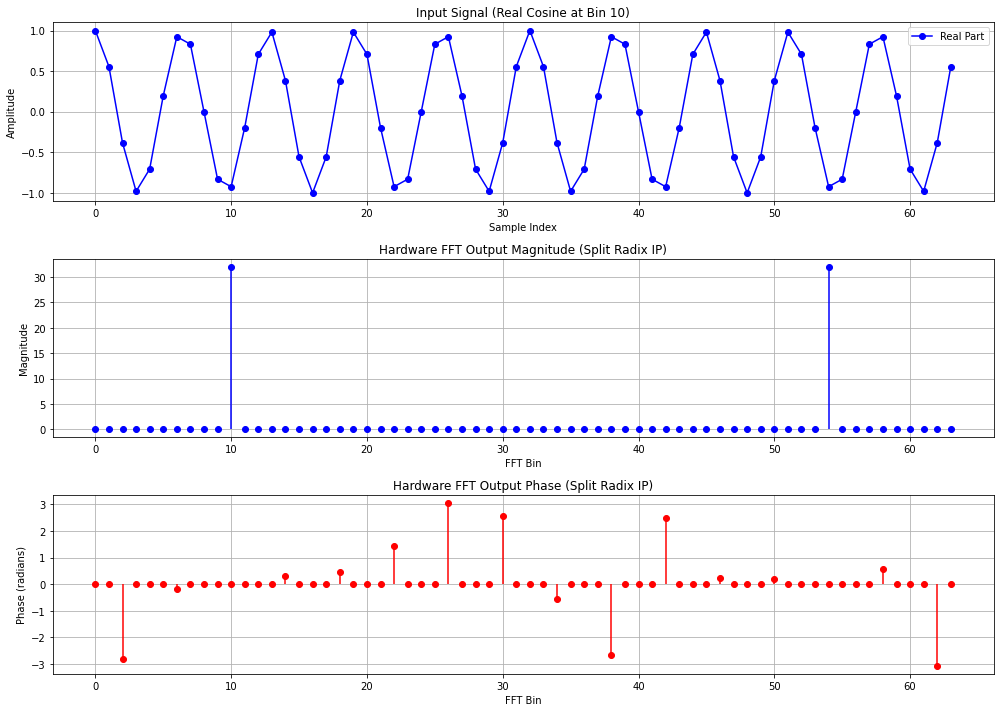

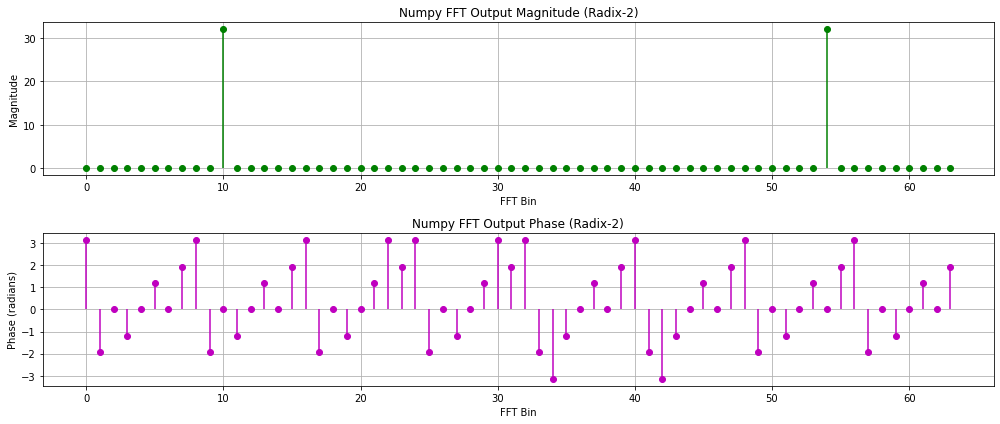

In [14]:
import numpy as np
import time
from pynq import MMIO
import matplotlib.pyplot as plt

CTRL_BASEADDR = 0x40000000
CTRL_SPACE = 0x1000
N = 64
NUM_BANKS = 8
SAMPLES_PER_BANK = 8
FIXED_POINT_FRACTIONAL = 16

INPUT_OFFSETS = [0x040 + 0x40 * i for i in range(NUM_BANKS)]
OUTPUT_OFFSETS = [0x240 + 0x40 * i for i in range(NUM_BANKS)]
AP_CTRL_OFFSET = 0x000

mmio = MMIO(CTRL_BASEADDR, CTRL_SPACE)

def float_to_fixed(flt):
    scaled = int(np.round(flt * (1 << FIXED_POINT_FRACTIONAL)))
    if scaled >= (1 << 31):
        scaled -= (1 << 32)
    elif scaled < -(1 << 31):
        scaled += (1 << 32)
    return np.uint32(scaled & 0xFFFFFFFF)

def fixed_to_float(fx):
    fx &= 0xFFFFFFFF
    if fx & 0x80000000:
        fx_signed = fx - 0x100000000
    else:
        fx_signed = fx
    return fx_signed / float(1 << FIXED_POINT_FRACTIONAL)

def write_complex_bank(bank_num, complex_data):
    if len(complex_data) != SAMPLES_PER_BANK:
        raise ValueError(f"Bank {bank_num} must have exactly {SAMPLES_PER_BANK} samples")
    base = INPUT_OFFSETS[bank_num]
    for i, c in enumerate(complex_data):
        real_fixed = float_to_fixed(np.real(c))
        imag_fixed = float_to_fixed(np.imag(c))
        mmio.write(base + i * 8, int(real_fixed))
        mmio.write(base + i * 8 + 4, int(imag_fixed))

def read_complex_bank(bank_num):
    base = OUTPUT_OFFSETS[bank_num]
    complex_vals = []
    for i in range(SAMPLES_PER_BANK):
        real_fixed = mmio.read(base + i * 8)
        imag_fixed = mmio.read(base + i * 8 + 4)
        real_float = fixed_to_float(real_fixed)
        imag_float = fixed_to_float(imag_fixed)
        complex_vals.append(real_float + 1j * imag_float)
    return np.array(complex_vals, dtype=np.complex64)

def write_all_input_banks(input_data):
    if len(input_data) != N:
        raise ValueError(f"Input data length must be {N}")
    for b in range(NUM_BANKS):
        bank_data = input_data[b*SAMPLES_PER_BANK:(b+1)*SAMPLES_PER_BANK]
        write_complex_bank(b, bank_data)

def read_all_output_banks():
    output_data = []
    for b in range(NUM_BANKS):
        bank_data = read_complex_bank(b)
        output_data.extend(bank_data)
    return np.array(output_data)

def start_fft():
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    mmio.write(AP_CTRL_OFFSET, ctrl_val | 0x1)

def is_fft_done():
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    return ((ctrl_val >> 1) & 0x1) == 1

def wait_for_fft_done(timeout=2.0):
    start_time = time.time()
    while not is_fft_done():
        if time.time() - start_time > timeout:
            raise TimeoutError("FFT did not complete in time")
        time.sleep(0.001)

def reset_ip():
    mmio.write(AP_CTRL_OFFSET, 0)

def generate_cosine_input(freq_bin=10):
    # Real cosine wave, imaginary part zeros
    input_signal = np.zeros(N, dtype=np.complex64)
    for i in range(N):
        phase = 2 * np.pi * freq_bin * i / N
        input_signal[i] = np.cos(phase) + 0j  # Imaginary part zero
    return input_signal

def run_cosine_test_and_plot(freq_bin=10):
    print("Resetting IP...")
    reset_ip()
    time.sleep(0.01)

    print("Generating cosine input signal...")
    input_signal = generate_cosine_input(freq_bin)

    print("Writing input data to IP...")
    write_all_input_banks(input_signal)

    print("Starting FFT...")
    start_fft()

    print("Waiting for FFT to complete...")
    wait_for_fft_done()

    print("Reading FFT output...")
    hw_fft_output = read_all_output_banks()

    print("Calculating numpy FFT...")
    np_fft_output = np.fft.fft(input_signal)

    # Plot input signal real and imaginary parts
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 1, 1)
    plt.plot(np.real(input_signal), 'b-o', label='Real Part')

    plt.title('Input Signal (Real Cosine at Bin %d)' % freq_bin)
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()

    # Plot hardware FFT output magnitude and phase
    plt.subplot(3, 1, 2)
    plt.stem(np.abs(hw_fft_output), linefmt='b-', markerfmt='bo', basefmt=' ')
    plt.title('Hardware FFT Output Magnitude (Split Radix IP)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Magnitude')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.stem(np.angle(hw_fft_output), linefmt='r-', markerfmt='ro', basefmt=' ')
    plt.title('Hardware FFT Output Phase (Split Radix IP)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Phase (radians)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Additional plot for numpy FFT output magnitude and phase for comparison
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    plt.stem(np.abs(np_fft_output), linefmt='g-', markerfmt='go', basefmt=' ')
    plt.title('Numpy FFT Output Magnitude (Radix-2)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Magnitude')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.stem(np.angle(np_fft_output), linefmt='m-', markerfmt='mo', basefmt=' ')
    plt.title('Numpy FFT Output Phase (Radix-2)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Phase (radians)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return hw_fft_output, np_fft_output

# Run cosine test for frequency bin 10 with plots and comparison
hw_fft_cos, np_fft_cos = run_cosine_test_and_plot(10)


Bin	HW		NumPy
0	2080.0000	2080.0000
1	652.1583	652.1605
2	326.4722	326.4735
3	218.0886	218.0869
4	164.0264	164.0266
5	131.7003	131.6980
6	110.2371	110.2366
7	94.9879	94.9865
8	83.6199	83.6200
9	74.8448	74.8442
10	67.8847	67.8834
11	62.2452	62.2444
12	57.5991	57.5985
13	53.7204	53.7184
14	50.4430	50.4419
15	47.6530	47.6503
16	45.2548	45.2548
17	43.1905	43.1877
18	41.3966	41.3966
19	39.8406	39.8403
20	38.4865	38.4861
21	37.3083	37.3078
22	36.2841	36.2844
23	35.3979	35.3986
24	34.6364	34.6366
25	33.9871	33.9867
26	33.4400	33.4399
27	32.9906	32.9886
28	32.6270	32.6269
29	32.3512	32.3501
30	32.1541	32.1548
31	32.0396	32.0386
32	32.0000	32.0000
33	32.0411	32.0386
34	32.1554	32.1548
35	32.3530	32.3501
36	32.6274	32.6269
37	32.9892	32.9886
38	33.4394	33.4399
39	33.9877	33.9867
40	34.6370	34.6366
41	35.4007	35.3986
42	36.2858	36.2844
43	37.3089	37.3078
44	38.4870	38.4861
45	39.8408	39.8403
46	41.3966	41.3966
47	43.1897	43.1877
48	45.2548	45.2548
49	47.6502	47.6503
50	50.4414	50.4419
51	53.7184	

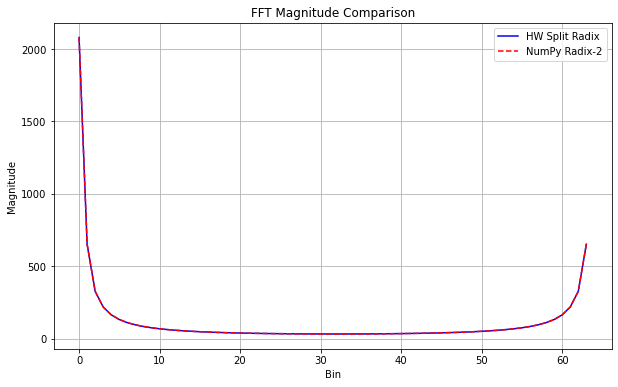

In [15]:
import numpy as np
import time
from pynq import MMIO
import matplotlib.pyplot as plt

CTRL_BASEADDR = 0x40000000
CTRL_SPACE = 0x1000
N = 64
NUM_BANKS = 8
SAMPLES_PER_BANK = 8
FIXED_POINT_FRACTIONAL = 16

INPUT_OFFSETS = [0x040 + 0x40 * i for i in range(NUM_BANKS)]
OUTPUT_OFFSETS = [0x240 + 0x40 * i for i in range(NUM_BANKS)]
AP_CTRL_OFFSET = 0x000

mmio = MMIO(CTRL_BASEADDR, CTRL_SPACE)

def float_to_fixed(flt):
    scaled = int(np.round(flt * (1 << FIXED_POINT_FRACTIONAL)))
    if scaled >= (1 << 31):
        scaled -= (1 << 32)
    elif scaled < -(1 << 31):
        scaled += (1 << 32)
    return np.uint32(scaled & 0xFFFFFFFF)

def float_to_fixed(flt):
    scaled = int(np.round(flt * (1 << FIXED_POINT_FRACTIONAL)))
    if scaled >= (1 << 31):
        scaled -= (1 << 32)
    elif scaled < -(1 << 31):
        scaled += (1 << 32)
    return np.uint32(scaled & 0xFFFFFFFF)

def write_complex_bank(bank_num, complex_data):
    base = INPUT_OFFSETS[bank_num]
    for i, c in enumerate(complex_data):
        mmio.write(base + i*8, int(float_to_fixed(c.real)))
        mmio.write(base + i*8+4, int(float_to_fixed(c.imag)))


def read_complex_bank(bank_num):
    base = OUTPUT_OFFSETS[bank_num]
    vals = []
    for i in range(SAMPLES_PER_BANK):
        r = fixed_to_float(mmio.read(base + i*8))
        im = fixed_to_float(mmio.read(base + i*8+4))
        vals.append(r + 1j*im)
    return np.array(vals)

def write_all(input_data):
    for b in range(NUM_BANKS):
        chunk = input_data[b*SAMPLES_PER_BANK:(b+1)*SAMPLES_PER_BANK]
        write_complex_bank(b, chunk)

def read_all():
    out = []
    for b in range(NUM_BANKS):
        out.extend(read_complex_bank(b))
    return np.array(out)

def start_fft():
    mmio.write(AP_CTRL_OFFSET, mmio.read(AP_CTRL_OFFSET)|1)

def fft_done():
    return bool((mmio.read(AP_CTRL_OFFSET)>>1)&1)

def wait_done(timeout=2.0):
    t0 = time.time()
    while not fft_done():
        if time.time()-t0>timeout:
            raise TimeoutError("FFT timed out")
        time.sleep(0.001)

def reset_ip():
    mmio.write(AP_CTRL_OFFSET,0)

def test_discrete(input_seq):
    if len(input_seq)!=N:
        raise ValueError("Input must be length 64")
    # to complex
    inp = np.array(input_seq, dtype=np.complex64)
    reset_ip(); time.sleep(0.01)
    write_all(inp)
    start_fft(); wait_done()
    hw_out = read_all()
    np_out = np.fft.fft(inp)
    # print magnitudes
    print("Bin\tHW\t\tNumPy")
    for i in range(N):
        print(f"{i}\t{abs(hw_out[i]):.4f}\t{abs(np_out[i]):.4f}")
    # plot comparison
    plt.figure(figsize=(10,6))
    plt.plot(abs(hw_out), 'b-', label='HW Split Radix')
    plt.plot(abs(np_out), 'r--', label='NumPy Radix-2')
    plt.title('FFT Magnitude Comparison')
    plt.xlabel('Bin')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True)
    plt.show()
    return hw_out, np_out

# Example discrete sequence: 1,2,3,...,64
sequence = np.arange(1, N+1)
hw_fft, np_fft = test_discrete(sequence)


Resetting IP...
Generating random discrete input signal...
Writing input data to IP...
Starting FFT...
Waiting for FFT to complete...
Reading FFT output...
Calculating numpy FFT...


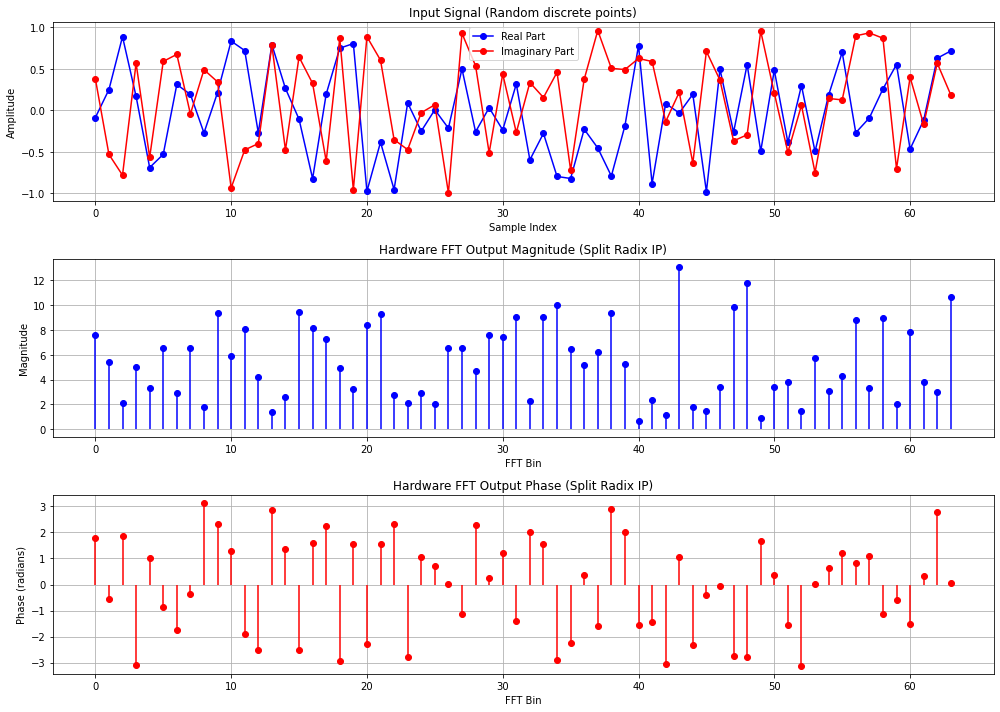

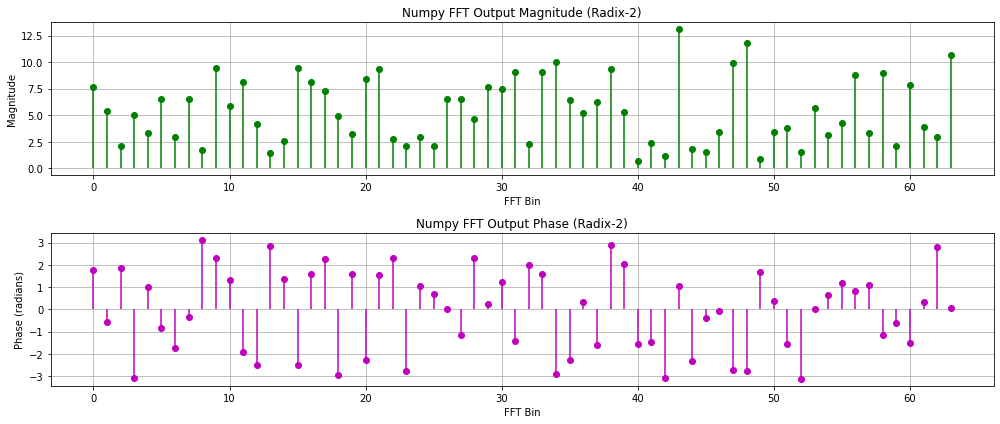

In [16]:
import numpy as np
import time
from pynq import MMIO
import matplotlib.pyplot as plt

CTRL_BASEADDR = 0x40000000
CTRL_SPACE = 0x1000
N = 64
NUM_BANKS = 8
SAMPLES_PER_BANK = 8
FIXED_POINT_FRACTIONAL = 16
INPUT_OFFSETS = [0x040 + 0x40 * i for i in range(NUM_BANKS)]
OUTPUT_OFFSETS = [0x240 + 0x40 * i for i in range(NUM_BANKS)]
AP_CTRL_OFFSET = 0x000

mmio = MMIO(CTRL_BASEADDR, CTRL_SPACE)

def float_to_fixed(flt):
    scaled = int(np.round(flt * (1 << FIXED_POINT_FRACTIONAL)))
    if scaled >= (1 << 31):
        scaled -= (1 << 32)
    elif scaled < -(1 << 31):
        scaled += (1 << 32)
    return np.uint32(scaled & 0xFFFFFFFF)

def fixed_to_float(fx):
    fx &= 0xFFFFFFFF
    if fx & 0x80000000:
        fx_signed = fx - 0x100000000
    else:
        fx_signed = fx
    return fx_signed / float(1 << FIXED_POINT_FRACTIONAL)

def write_complex_bank(bank_num, complex_data):
    if len(complex_data) != SAMPLES_PER_BANK:
        raise ValueError(f"Bank {bank_num} must have exactly {SAMPLES_PER_BANK} samples")
    base = INPUT_OFFSETS[bank_num]
    for i, c in enumerate(complex_data):
        real_fixed = float_to_fixed(np.real(c))
        imag_fixed = float_to_fixed(np.imag(c))
        mmio.write(base + i * 8, int(real_fixed))
        mmio.write(base + i * 8 + 4, int(imag_fixed))

def read_complex_bank(bank_num):
    base = OUTPUT_OFFSETS[bank_num]
    complex_vals = []
    for i in range(SAMPLES_PER_BANK):
        real_fixed = mmio.read(base + i * 8)
        imag_fixed = mmio.read(base + i * 8 + 4)
        real_float = fixed_to_float(real_fixed)
        imag_float = fixed_to_float(imag_fixed)
        complex_vals.append(real_float + 1j * imag_float)
    return np.array(complex_vals, dtype=np.complex64)

def write_all_input_banks(input_data):
    if len(input_data) != N:
        raise ValueError(f"Input data length must be {N}")
    for b in range(NUM_BANKS):
        bank_data = input_data[b*SAMPLES_PER_BANK:(b+1)*SAMPLES_PER_BANK]
        write_complex_bank(b, bank_data)

def read_all_output_banks():
    output_data = []
    for b in range(NUM_BANKS):
        bank_data = read_complex_bank(b)
        output_data.extend(bank_data)
    return np.array(output_data, dtype=np.complex64)

def start_fft():
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    mmio.write(AP_CTRL_OFFSET, ctrl_val | 0x1)

def is_fft_done():
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    return ((ctrl_val >> 1) & 0x1) == 1

def wait_for_fft_done(timeout=2.0):
    start_time = time.time()
    while not is_fft_done():
        if time.time() - start_time > timeout:
            raise TimeoutError("FFT did not complete in time")
        time.sleep(0.001)

def reset_ip():
    mmio.write(AP_CTRL_OFFSET, 0)

def generate_random_input():
    # Generate 64 random complex points with real and imaginary parts between -1 and 1
    real_parts = 2 * np.random.rand(N) - 1
    imag_parts = 2 * np.random.rand(N) - 1
    input_signal = real_parts + 1j * imag_parts
    return input_signal.astype(np.complex64)

def run_random_input_test_and_plot():
    print("Resetting IP...")
    reset_ip()
    time.sleep(0.01)
    print("Generating random discrete input signal...")
    input_signal = generate_random_input()
    print("Writing input data to IP...")
    write_all_input_banks(input_signal)
    print("Starting FFT...")
    start_fft()
    print("Waiting for FFT to complete...")
    wait_for_fft_done()
    print("Reading FFT output...")
    hw_fft_output = read_all_output_banks()
    print("Calculating numpy FFT...")
    np_fft_output = np.fft.fft(input_signal)

    # Plot input signal real and imaginary parts
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 1, 1)
    plt.plot(np.real(input_signal), 'b-o', label='Real Part')
    plt.plot(np.imag(input_signal), 'r-o', label='Imaginary Part')
    plt.title('Input Signal (Random discrete points)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()

    # Plot hardware FFT output magnitude and phase
    plt.subplot(3, 1, 2)
    plt.stem(np.abs(hw_fft_output), linefmt='b-', markerfmt='bo', basefmt=' ')
    plt.title('Hardware FFT Output Magnitude (Split Radix IP)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Magnitude')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.stem(np.angle(hw_fft_output), linefmt='r-', markerfmt='ro', basefmt=' ')
    plt.title('Hardware FFT Output Phase (Split Radix IP)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Phase (radians)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot numpy FFT output magnitude and phase for comparison
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    plt.stem(np.abs(np_fft_output), linefmt='g-', markerfmt='go', basefmt=' ')
    plt.title('Numpy FFT Output Magnitude (Radix-2)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Magnitude')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.stem(np.angle(np_fft_output), linefmt='m-', markerfmt='mo', basefmt=' ')
    plt.title('Numpy FFT Output Phase (Radix-2)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Phase (radians)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return hw_fft_output, np_fft_output

# Run the random input FFT test and plot
hw_fft_out, np_fft_out = run_random_input_test_and_plot()


Resetting IP...
Generating random discrete input signal...
Writing input data to IP...
Starting FFT...
Waiting for FFT to complete...
Reading FFT output...
Calculating numpy FFT...
FFT Output Error Percentage (NMSE * 100): 0.000000%


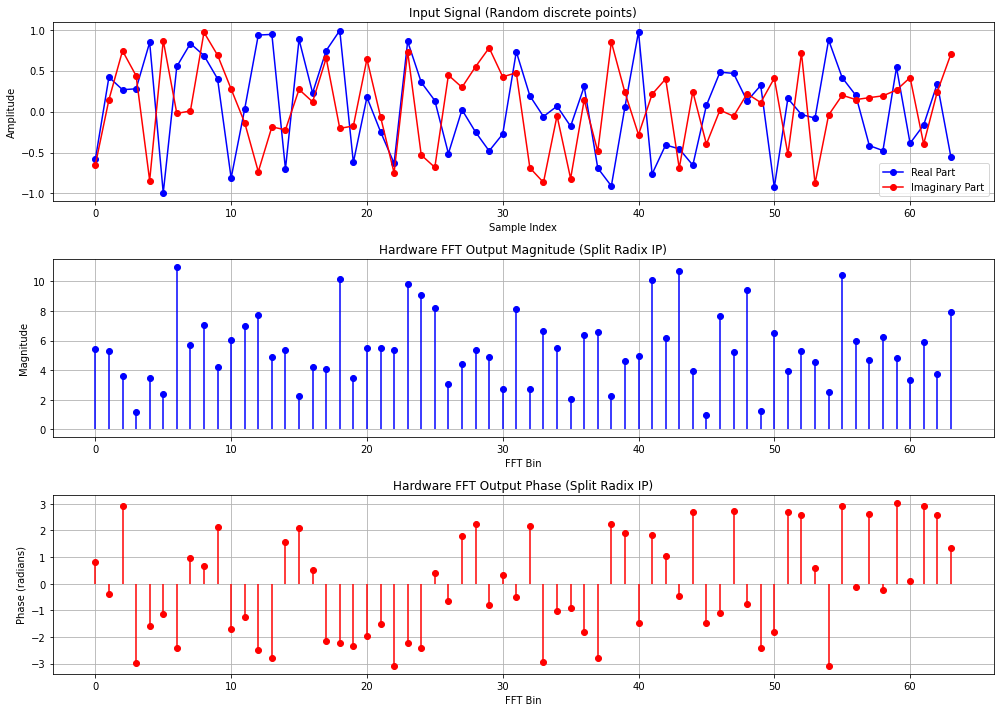

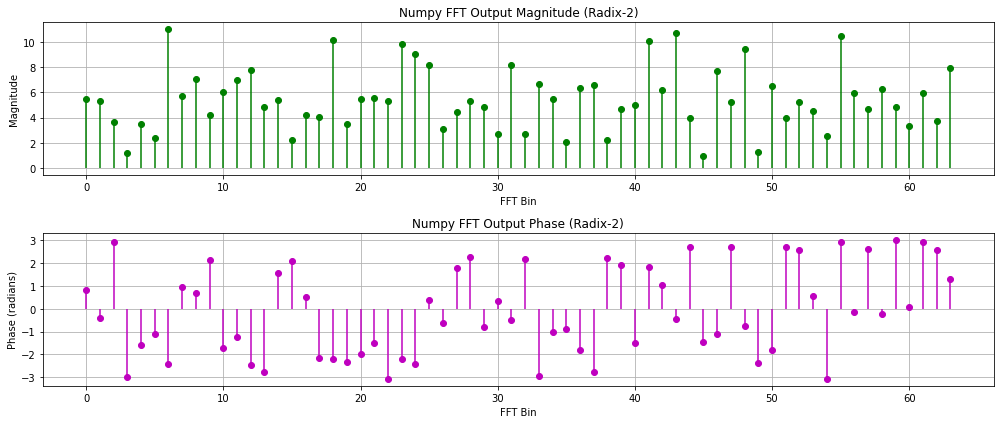

In [17]:
import numpy as np
import time
from pynq import MMIO
import matplotlib.pyplot as plt

CTRL_BASEADDR = 0x40000000
CTRL_SPACE = 0x1000
N = 64
NUM_BANKS = 8
SAMPLES_PER_BANK = 8
FIXED_POINT_FRACTIONAL = 16
INPUT_OFFSETS = [0x040 + 0x40 * i for i in range(NUM_BANKS)]
OUTPUT_OFFSETS = [0x240 + 0x40 * i for i in range(NUM_BANKS)]
AP_CTRL_OFFSET = 0x000

mmio = MMIO(CTRL_BASEADDR, CTRL_SPACE)

def float_to_fixed(flt):
    scaled = int(np.round(flt * (1 << FIXED_POINT_FRACTIONAL)))
    if scaled >= (1 << 31):
        scaled -= (1 << 32)
    elif scaled < -(1 << 31):
        scaled += (1 << 32)
    return np.uint32(scaled & 0xFFFFFFFF)

def fixed_to_float(fx):
    fx &= 0xFFFFFFFF
    if fx & 0x80000000:
        fx_signed = fx - 0x100000000
    else:
        fx_signed = fx
    return fx_signed / float(1 << FIXED_POINT_FRACTIONAL)

def write_complex_bank(bank_num, complex_data):
    if len(complex_data) != SAMPLES_PER_BANK:
        raise ValueError(f"Bank {bank_num} must have exactly {SAMPLES_PER_BANK} samples")
    base = INPUT_OFFSETS[bank_num]
    for i, c in enumerate(complex_data):
        real_fixed = float_to_fixed(np.real(c))
        imag_fixed = float_to_fixed(np.imag(c))
        mmio.write(base + i * 8, int(real_fixed))
        mmio.write(base + i * 8 + 4, int(imag_fixed))

def read_complex_bank(bank_num):
    base = OUTPUT_OFFSETS[bank_num]
    complex_vals = []
    for i in range(SAMPLES_PER_BANK):
        real_fixed = mmio.read(base + i * 8)
        imag_fixed = mmio.read(base + i * 8 + 4)
        real_float = fixed_to_float(real_fixed)
        imag_float = fixed_to_float(imag_fixed)
        complex_vals.append(real_float + 1j * imag_float)
    return np.array(complex_vals, dtype=np.complex64)

def write_all_input_banks(input_data):
    if len(input_data) != N:
        raise ValueError(f"Input data length must be {N}")
    for b in range(NUM_BANKS):
        bank_data = input_data[b*SAMPLES_PER_BANK:(b+1)*SAMPLES_PER_BANK]
        write_complex_bank(b, bank_data)

def read_all_output_banks():
    output_data = []
    for b in range(NUM_BANKS):
        bank_data = read_complex_bank(b)
        output_data.extend(bank_data)
    return np.array(output_data, dtype=np.complex64)

def start_fft():
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    mmio.write(AP_CTRL_OFFSET, ctrl_val | 0x1)

def is_fft_done():
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    return ((ctrl_val >> 1) & 0x1) == 1

def wait_for_fft_done(timeout=2.0):
    start_time = time.time()
    while not is_fft_done():
        if time.time() - start_time > timeout:
            raise TimeoutError("FFT did not complete in time")
        time.sleep(0.001)

def reset_ip():
    mmio.write(AP_CTRL_OFFSET, 0)

def generate_random_input():
    # Generate 64 random complex points with real and imaginary parts between -1 and 1
    real_parts = 2 * np.random.rand(N) - 1
    imag_parts = 2 * np.random.rand(N) - 1
    input_signal = real_parts + 1j * imag_parts
    return input_signal.astype(np.complex64)

def calculate_error_percent(hw_output, np_output):
    # Normalized Mean Square Error (NMSE) between hardware and numpy outputs
    error = np.sum(np.abs(hw_output - np_output)**2) / np.sum(np.abs(np_output)**2)
    return error * 100

def run_random_input_test_and_plot():
    print("Resetting IP...")
    reset_ip()
    time.sleep(0.01)
    print("Generating random discrete input signal...")
    input_signal = generate_random_input()
    print("Writing input data to IP...")
    write_all_input_banks(input_signal)
    print("Starting FFT...")
    start_fft()
    print("Waiting for FFT to complete...")
    wait_for_fft_done()
    print("Reading FFT output...")
    hw_fft_output = read_all_output_banks()
    print("Calculating numpy FFT...")
    np_fft_output = np.fft.fft(input_signal)

    # Calculate and print error percentage
    err_percent = calculate_error_percent(hw_fft_output, np_fft_output)
    print(f"FFT Output Error Percentage (NMSE * 100): {err_percent:.6f}%")

    # Plot input signal real and imaginary parts
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 1, 1)
    plt.plot(np.real(input_signal), 'b-o', label='Real Part')
    plt.plot(np.imag(input_signal), 'r-o', label='Imaginary Part')
    plt.title('Input Signal (Random discrete points)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()

    # Plot hardware FFT output magnitude and phase
    plt.subplot(3, 1, 2)
    plt.stem(np.abs(hw_fft_output), linefmt='b-', markerfmt='bo', basefmt=' ')
    plt.title('Hardware FFT Output Magnitude (Split Radix IP)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Magnitude')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.stem(np.angle(hw_fft_output), linefmt='r-', markerfmt='ro', basefmt=' ')
    plt.title('Hardware FFT Output Phase (Split Radix IP)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Phase (radians)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot numpy FFT output magnitude and phase for comparison
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    plt.stem(np.abs(np_fft_output), linefmt='g-', markerfmt='go', basefmt=' ')
    plt.title('Numpy FFT Output Magnitude (Radix-2)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Magnitude')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.stem(np.angle(np_fft_output), linefmt='m-', markerfmt='mo', basefmt=' ')
    plt.title('Numpy FFT Output Phase (Radix-2)')
    plt.xlabel('FFT Bin')
    plt.ylabel('Phase (radians)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return hw_fft_output, np_fft_output

# Run the random input FFT test and plot with error percentage
hw_fft_out, np_fft_out = run_random_input_test_and_plot()


Resetting IP
Generating quantized sine wave
Writing input to IP
Starting FFT IP
Waiting for finish
Reading output
FFT error percentage (NMSE*100): 0.000000%


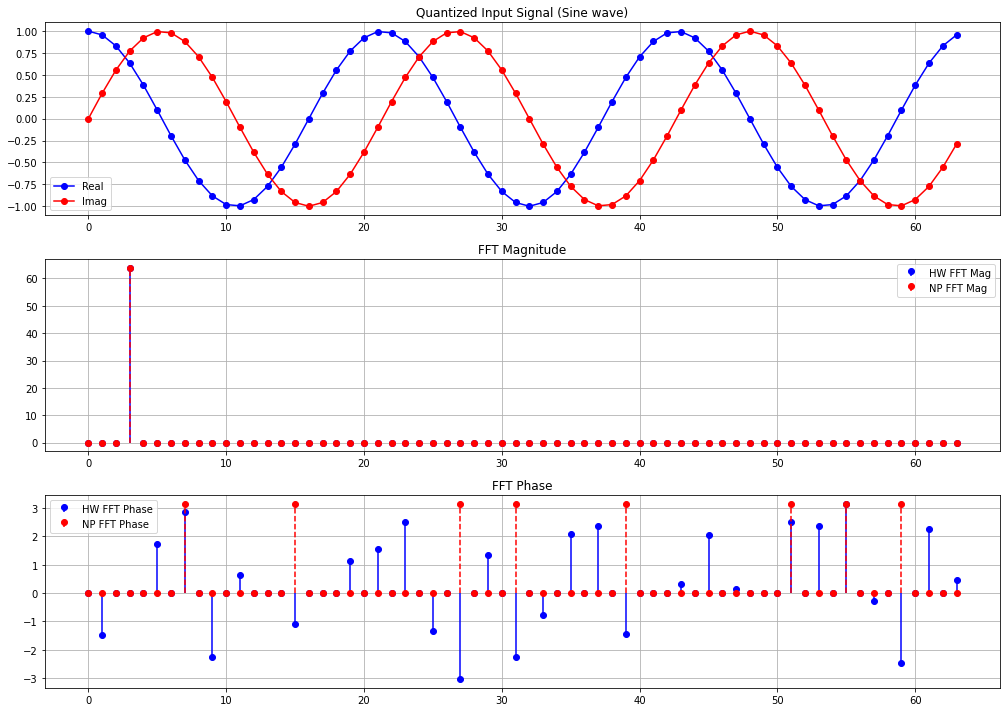

In [18]:
import numpy as np
import time
from pynq import MMIO
import matplotlib.pyplot as plt

CTRL_BASEADDR = 0x40000000
CTRL_SPACE = 0x1000
N = 64  # FFT length
NUM_BANKS = 8
SAMPLES_PER_BANK = 8
FIXED_POINT_FRACTIONAL = 16  # fractional bits for fixed-point Q16 format
INPUT_OFFSETS = [0x040 + 0x40 * i for i in range(NUM_BANKS)]  # IP input memory offsets
OUTPUT_OFFSETS = [0x240 + 0x40 * i for i in range(NUM_BANKS)]  # IP output memory offsets
AP_CTRL_OFFSET = 0x000

mmio = MMIO(CTRL_BASEADDR, CTRL_SPACE)

def float_to_fixed(val):
    """ Convert floating point value [-1,1) to fixed-point Q16 32-bit signed int """
    scaled = int(np.round(val * (1 << FIXED_POINT_FRACTIONAL)))
    # Saturate to 32-bit signed int range
    if scaled >= (1 << 31):
        scaled -= (1 << 32)
    elif scaled < -(1 << 31):
        scaled += (1 << 32)
    return np.uint32(scaled & 0xFFFFFFFF)  # store as unsigned for hardware writing

def fixed_to_float(val):
    """ Convert 32-bit fixed point back to float for verification """
    val &= 0xFFFFFFFF
    if val & 0x80000000:
        val -= 0x100000000
    return val / float(1 << FIXED_POINT_FRACTIONAL)

def generate_quantized_sinecos_wave(N, freq=1, phase=0):
    """ Generate complex sine wave samples, quantized to Q16 fixed-point """
    t = np.arange(N)
    # Continuous waveform sampled discretely:
    real = np.cos(2 * np.pi * freq * t / N + phase)
    imag = np.sin(2 * np.pi * freq * t / N + phase)
    # Quantize each sample:
    real_fixed = np.array([float_to_fixed(x) for x in real], dtype=np.uint32)
    imag_fixed = np.array([float_to_fixed(x) for x in imag], dtype=np.uint32)
    # Combine into complex integer representation (real + j*imag)
    return real_fixed, imag_fixed

def write_input_to_ip(real_fixed, imag_fixed):
    """ Write quantized real and imaginary parts interleaved per IP format """
    # IP expects 64-bit complex number stored as two 32-bit registers:
    # lower 32 bits: real part, upper 32 bits: imag part
    # Write in banks (8 samples per bank)
    for bank in range(NUM_BANKS):
        base = INPUT_OFFSETS[bank]
        for i in range(SAMPLES_PER_BANK):
            idx = bank * SAMPLES_PER_BANK + i
            mmio.write(base + i*8, int(real_fixed[idx]))
            mmio.write(base + i*8 + 4, int(imag_fixed[idx]))

def read_output_from_ip():
    """ Read 64 complex samples output (64-bit each) from IP """
    output = np.zeros(N, dtype=np.complex64)
    for bank in range(NUM_BANKS):
        base = OUTPUT_OFFSETS[bank]
        for i in range(SAMPLES_PER_BANK):
            real_fixed = mmio.read(base + i*8)
            imag_fixed = mmio.read(base + i*8 + 4)
            real = fixed_to_float(real_fixed)
            imag = fixed_to_float(imag_fixed)
            idx = bank * SAMPLES_PER_BANK + i
            output[idx] = real + 1j * imag
    return output

def start_fft():
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    mmio.write(AP_CTRL_OFFSET, ctrl_val | 0x1)

def is_fft_done():
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    return ((ctrl_val >> 1) & 0x1) == 1

def wait_for_finish(timeout=2.0):
    start_time = time.time()
    while not is_fft_done():
        if time.time() - start_time > timeout:
            raise TimeoutError("FFT not done within timeout")
        time.sleep(0.001)

def reset_ip():
    mmio.write(AP_CTRL_OFFSET, 0)

def calculate_error_percent(hw_fft, np_fft):
    err = np.sum(np.abs(hw_fft - np_fft)**2) / np.sum(np.abs(np_fft)**2)
    return err * 100

def run_quantized_sine_test():
    print("Resetting IP")
    reset_ip()
    time.sleep(0.01)
    print("Generating quantized sine wave")
    real_fixed, imag_fixed = generate_quantized_sinecos_wave(N, freq=3)  # freq=3 as example
    print("Writing input to IP")
    write_input_to_ip(real_fixed, imag_fixed)
    print("Starting FFT IP")
    start_fft()
    print("Waiting for finish")
    wait_for_finish()
    print("Reading output")
    hw_output = read_output_from_ip()
    # Reference FFT from numpy on float data (scaled back from fixed)
    real_float = np.array([fixed_to_float(r) for r in real_fixed])
    imag_float = np.array([fixed_to_float(i) for i in imag_fixed])
    input_complex = real_float + 1j * imag_float
    np_output = np.fft.fft(input_complex)

    err_percent = calculate_error_percent(hw_output, np_output)
    print(f"FFT error percentage (NMSE*100): {err_percent:.6f}%")

    # Plot input, hardware and numpy FFT output magnitudes and phases
    import matplotlib.pyplot as plt
    plt.figure(figsize=(14,10))

    plt.subplot(3,1,1)
    plt.plot(input_complex.real, 'b-o', label='Real')
    plt.plot(input_complex.imag, 'r-o', label='Imag')
    plt.title('Quantized Input Signal (Sine wave)')
    plt.legend()
    plt.grid(True)

    plt.subplot(3,1,2)
    plt.stem(np.abs(hw_output), linefmt='b-', markerfmt='bo', basefmt=' ', label='HW FFT Mag')
    plt.stem(np.abs(np_output), linefmt='r--', markerfmt='ro', basefmt=' ', label='NP FFT Mag', use_line_collection=True)
    plt.title('FFT Magnitude')
    plt.legend()
    plt.grid(True)

    plt.subplot(3,1,3)
    plt.stem(np.angle(hw_output), linefmt='b-', markerfmt='bo', basefmt=' ', label='HW FFT Phase')
    plt.stem(np.angle(np_output), linefmt='r--', markerfmt='ro', basefmt=' ', label='NP FFT Phase', use_line_collection=True)
    plt.title('FFT Phase')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return hw_output, np_output

# Run test with quantized sine input
hw_fft_out, np_fft_out = run_quantized_sine_test()


Resetting IP...
Generating quantized complex sine wave at bin 3, phase 0.0 rad
Writing quantized input to hardware FFT IP...
Starting FFT IP...
Waiting for FFT to complete...
Reading FFT hardware output...
Computing numpy FFT from same quantized input...
Normalized Mean Squared Error (NMSE) * 100: 0.000000%
Average Phase Error (radians): 1.459869


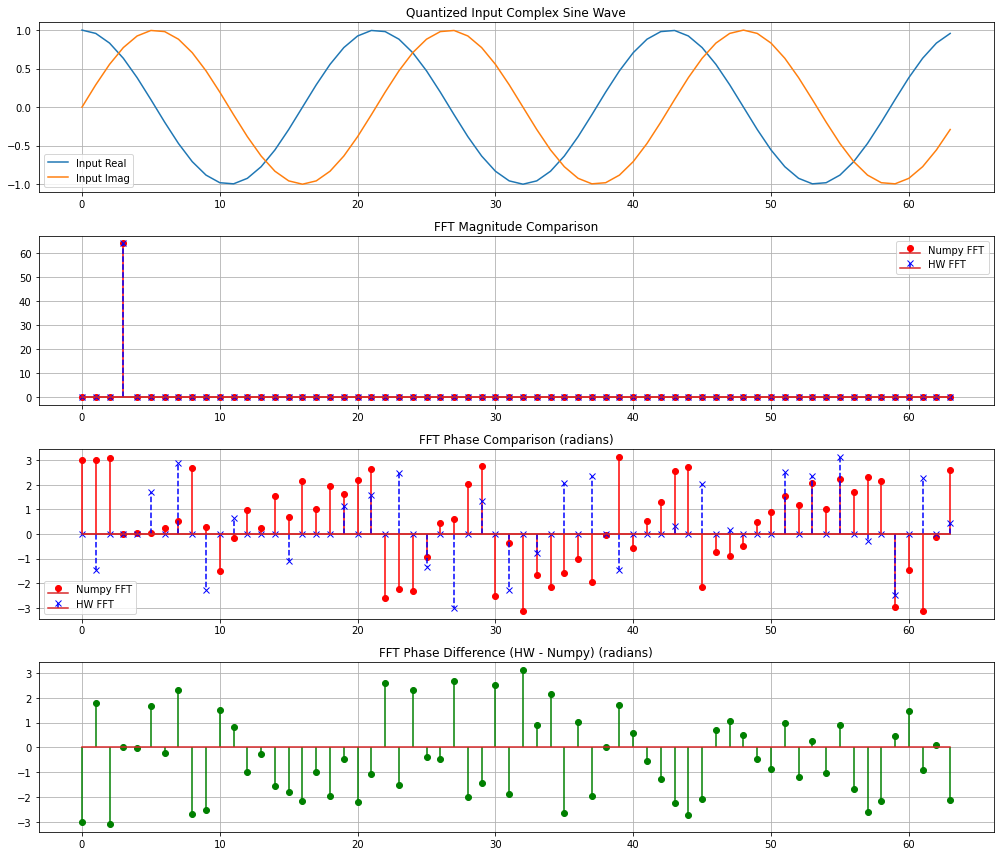

In [19]:
import numpy as np
import time
from pynq import MMIO
import matplotlib.pyplot as plt

# === Hardware IP constants === #
CTRL_BASEADDR = 0x40000000  # Replace with your base address
CTRL_SPACE = 0x1000
N = 64  # FFT size
NUM_BANKS = 8
SAMPLES_PER_BANK = 8
FIXED_POINT_FRACTIONAL = 16  # Q16 format fractional bits
INPUT_OFFSETS = [0x040 + 0x40 * i for i in range(NUM_BANKS)]  # IP input offsets
OUTPUT_OFFSETS = [0x240 + 0x40 * i for i in range(NUM_BANKS)]  # IP output offsets
AP_CTRL_OFFSET = 0x000

mmio = MMIO(CTRL_BASEADDR, CTRL_SPACE)

# --- Helper conversion functions ---

def float_to_fixed(val):
    """Convert float in [-1, 1) to Q16 32-bit unsigned int representation for hardware."""
    scaled = int(np.round(val * (1 << FIXED_POINT_FRACTIONAL)))
    if scaled >= (1 << 31):
        scaled -= (1 << 32)
    elif scaled < -(1 << 31):
        scaled += (1 << 32)
    return np.uint32(scaled & 0xFFFFFFFF)

def fixed_to_float(val):
    """Convert uint32 fixed-point to float."""
    val = val & 0xFFFFFFFF
    if val & 0x80000000:
        val -= 0x100000000
    return val / float(1 << FIXED_POINT_FRACTIONAL)

# --- Input generation with exact sampling and quantization ---

def generate_quantized_complex_wave(N, freq_bin=3, phase_rad=0.0):
    """
    Generate quantized complex sine wave samples for FFT input.
    freq_bin: integer frequency bin index < N
    phase_rad: initial continuous phase in radians
    """
    n = np.arange(N)
    # Discrete samples: e^(j*(2pi*f*n/N + phase))
    real_vals = np.cos(2 * np.pi * freq_bin * n / N + phase_rad)
    imag_vals = np.sin(2 * np.pi * freq_bin * n / N + phase_rad)
    real_fixed = np.array([float_to_fixed(r) for r in real_vals], dtype=np.uint32)
    imag_fixed = np.array([float_to_fixed(i) for i in imag_vals], dtype=np.uint32)
    return real_vals + 1j * imag_vals, real_fixed, imag_fixed

# --- Hardware write/read functions ---

def write_input_to_ip(real_fixed, imag_fixed):
    for bank in range(NUM_BANKS):
        base = INPUT_OFFSETS[bank]
        for i in range(SAMPLES_PER_BANK):
            idx = bank * SAMPLES_PER_BANK + i
            mmio.write(base + i*8, int(real_fixed[idx]))
            mmio.write(base + i*8 + 4, int(imag_fixed[idx]))

def read_output_from_ip():
    output_complex = np.zeros(N, dtype=np.complex64)
    for bank in range(NUM_BANKS):
        base = OUTPUT_OFFSETS[bank]
        for i in range(SAMPLES_PER_BANK):
            real_fixed = mmio.read(base + i*8)
            imag_fixed = mmio.read(base + i*8 + 4)
            real_flt = fixed_to_float(real_fixed)
            imag_flt = fixed_to_float(imag_fixed)
            idx = bank * SAMPLES_PER_BANK + i
            output_complex[idx] = real_flt + 1j*imag_flt
    return output_complex

def start_fft():
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    mmio.write(AP_CTRL_OFFSET, ctrl_val | 0x1)

def is_fft_done():
    ctrl_val = mmio.read(AP_CTRL_OFFSET)
    return ((ctrl_val >> 1) & 0x1) == 1

def wait_for_done(timeout=2.0):
    start = time.time()
    while not is_fft_done():
        if time.time() - start > timeout:
            raise TimeoutError("FFT not completed within timeout")
        time.sleep(0.001)

def reset_ip():
    mmio.write(AP_CTRL_OFFSET, 0)

# --- Error calculation for magnitude and phase alignment ---

def calculate_phase_error(hw_fft, np_fft):
    # Calculate phase difference error in radians, normalized between [-pi, pi]
    phase_diff = np.angle(hw_fft) - np.angle(np_fft)
    phase_diff = (phase_diff + np.pi) % (2 * np.pi) - np.pi
    return np.mean(np.abs(phase_diff))

def calculate_nmse(hw_fft, np_fft):
    return np.sum(np.abs(hw_fft - np_fft)**2) / np.sum(np.abs(np_fft)**2)

# --- Test routine ---

def run_quantized_sine_test(freq_bin=3, initial_phase=0.0):
    print("Resetting IP...")
    reset_ip()
    time.sleep(0.01)

    print(f"Generating quantized complex sine wave at bin {freq_bin}, phase {initial_phase} rad")
    float_input, real_fixed, imag_fixed = generate_quantized_complex_wave(N, freq_bin, initial_phase)

    print("Writing quantized input to hardware FFT IP...")
    write_input_to_ip(real_fixed, imag_fixed)

    print("Starting FFT IP...")
    start_fft()

    print("Waiting for FFT to complete...")
    wait_for_done()

    print("Reading FFT hardware output...")
    hw_fft_output = read_output_from_ip()

    print("Computing numpy FFT from same quantized input...")
    np_fft_output = np.fft.fft(float_input)

    nmse = calculate_nmse(hw_fft_output, np_fft_output) * 100
    phase_err = calculate_phase_error(hw_fft_output, np_fft_output)

    print(f"Normalized Mean Squared Error (NMSE) * 100: {nmse:.6f}%")
    print(f"Average Phase Error (radians): {phase_err:.6f}")

    # Plot
    plt.figure(figsize=(14, 12))
    plt.subplot(4,1,1)
    plt.plot(float_input.real, label='Input Real')
    plt.plot(float_input.imag, label='Input Imag')
    plt.title('Quantized Input Complex Sine Wave')
    plt.grid(True)
    plt.legend()

    plt.subplot(4,1,2)
    plt.stem(np.abs(np_fft_output), linefmt='r-', markerfmt='ro', label='Numpy FFT')
    plt.stem(np.abs(hw_fft_output), linefmt='b--', markerfmt='bx', label='HW FFT')
    plt.title('FFT Magnitude Comparison')
    plt.grid(True)
    plt.legend()

    plt.subplot(4,1,3)
    plt.stem(np.angle(np_fft_output), linefmt='r-', markerfmt='ro', label='Numpy FFT')
    plt.stem(np.angle(hw_fft_output), linefmt='b--', markerfmt='bx', label='HW FFT')
    plt.title('FFT Phase Comparison (radians)')
    plt.grid(True)
    plt.legend()

    plt.subplot(4,1,4)
    phase_diff = np.angle(hw_fft_output) - np.angle(np_fft_output)
    phase_diff = (phase_diff + np.pi) % (2 * np.pi) - np.pi
    plt.stem(phase_diff, linefmt='g-', markerfmt='go')
    plt.title('FFT Phase Difference (HW - Numpy) (radians)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return hw_fft_output, np_fft_output

# Example usage with freq_bin 3 and no initial phase offset (can adjust phase if needed)
hw_out, np_out = run_quantized_sine_test(freq_bin=3, initial_phase=0.0)


In [20]:
import numpy as np

N = 64
frac_bits = 16  # Q16 fixed point fractional bits

# Generate discrete sine wave samples over one period
k = np.arange(N)
sine_samples = np.sin(2 * np.pi * k / N)

# Quantize to Q16 fixed point
def float_to_fixed(x):
    scaled = int(np.round(x * (1 << frac_bits)))
    if scaled < 0:
        scaled += 1 << 32  # wrap negative numbers to unsigned 32-bit
    return np.uint32(scaled & 0xFFFFFFFF)

real_fixed = np.array([float_to_fixed(x) for x in sine_samples], dtype=np.uint32)
imag_fixed = np.zeros(N, dtype=np.uint32)  # Imaginary parts zero

# Now real_fixed and imag_fixed can be written to IP input banks sequentially


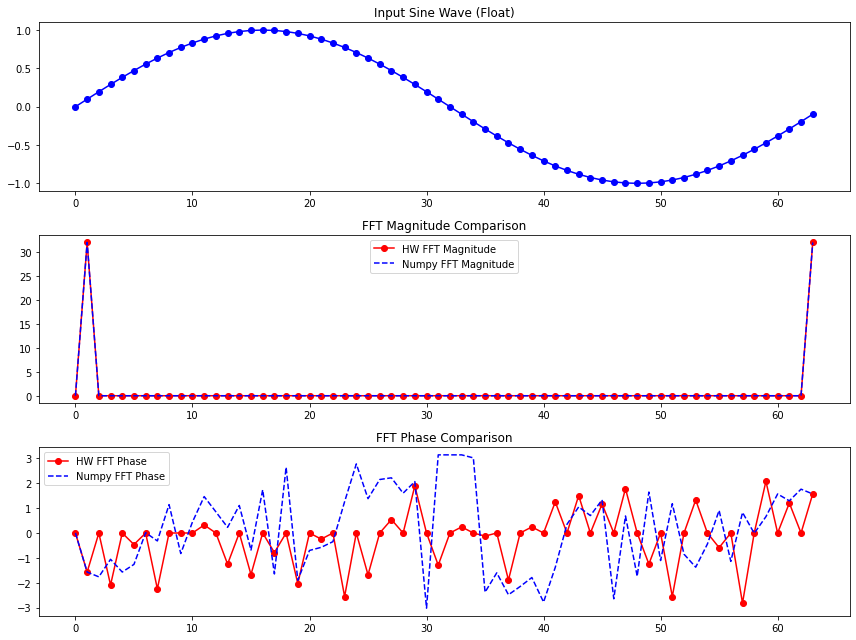

In [21]:
import numpy as np
import time
import matplotlib.pyplot as plt
import mmap
import os
import struct

# Constants from your hw header (offsets)
AP_CTRL = 0x000
GIE = 0x004
IER = 0x008
ISR = 0x00C

INPUT_BASES = [0x040 + i*0x40 for i in range(8)]
OUTPUT_BASES = [0x240 + i*0x40 for i in range(8)]
N_BANKS = 8
BANK_DEPTH = 8  # samples per bank
SAMPLES = N_BANKS * BANK_DEPTH  # 64 samples total
FIXED_FRAC_BITS = 16  # Q16 fixed point

# Memory size for mapping (adjust to size of control + all input/output memories)
# For example, mapping 0x440 bytes (max output base + memory depth)
MMAP_SIZE = 0x440  

# Replace this path with your actual UIO device or another mapped file/device for HW access
UIO_DEVICE = "/dev/uio0"

# Open and map the device
uio_fd = os.open(UIO_DEVICE, os.O_RDWR | os.O_SYNC)
m = mmap.mmap(uio_fd, MMAP_SIZE, mmap.MAP_SHARED, mmap.PROT_READ | mmap.PROT_WRITE, offset=0)


def read_reg(offset):
    # Read 32-bit register/memory at offset
    m.seek(offset)
    data = m.read(4)
    return struct.unpack("<I", data)[0]  # Little endian uint32


def write_reg(offset, value):
    # Write 32-bit register/memory at offset
    m.seek(offset)
    m.write(struct.pack("<I", value))


def float_to_fixed(x):
    val = int(round(x * (1 << FIXED_FRAC_BITS)))
    return val & 0xFFFFFFFF  # mask to 32-bit unsigned


def fixed_to_float(x):
    if x & 0x80000000:
        x = -((~x + 1) & 0xFFFFFFFF)  # 2's complement for signed negative
    return float(x) / (1 << FIXED_FRAC_BITS)


def write_complex_input(samples):
    """
    samples: numpy array of complex floats length 64
    Writes samples to all eight input banks.
    Each sample occupies 64 bits:
    word2n = real part (low 32 bits)
    word2n+1 = imag part (high 32 bits)
    """
    for bank in range(N_BANKS):
        base = INPUT_BASES[bank]
        for i in range(BANK_DEPTH):
            idx = bank * BANK_DEPTH + i
            real_fixed = float_to_fixed(samples[idx].real)
            imag_fixed = float_to_fixed(samples[idx].imag)
            # Write 64-bit sample as 2 words
            write_reg(base + i*8, real_fixed)
            write_reg(base + i*8 + 4, imag_fixed)


def read_complex_output():
    """
    Reads 64 complex samples from output banks.
    Returns numpy array of complex floats.
    """
    out = np.zeros(SAMPLES, dtype=np.complex64)
    for bank in range(N_BANKS):
        base = OUTPUT_BASES[bank]
        for i in range(BANK_DEPTH):
            idx = bank * BANK_DEPTH + i
            real_fixed = read_reg(base + i*8)
            imag_fixed = read_reg(base + i*8 + 4)
            out[idx] = complex(fixed_to_float(real_fixed), fixed_to_float(imag_fixed))
    return out


def start_fft():
    ctrl = read_reg(AP_CTRL)
    auto_restart = ctrl & 0x80
    # Clear the lower bits except auto_restart, then start = 1
    write_reg(AP_CTRL, auto_restart | 0x01)


def is_done():
    ctrl = read_reg(AP_CTRL)
    return ((ctrl >> 1) & 0x1) == 1


def wait_done(timeout=5.0):
    start = time.time()
    while not is_done():
        if time.time() - start > timeout:
            raise TimeoutError("FFT did not complete within timeout")
        time.sleep(0.001)


def main():
    # Generate test sine wave input
    k = np.arange(SAMPLES)
    sine_wave = np.sin(2 * np.pi * k / SAMPLES)
    input_samples = sine_wave + 0j  # Imag = 0

    # Write input samples
    write_complex_input(input_samples)

    # Start FFT
    start_fft()

    # Wait for completion
    wait_done()

    # Read output from hardware FFT
    hw_fft = read_complex_output()

    # Reference numpy FFT
    np_fft = np.fft.fft(input_samples)

    # Plot results
    plt.figure(figsize=(12, 9))

    plt.subplot(3, 1, 1)
    plt.plot(k, sine_wave, 'b-o')
    plt.title("Input Sine Wave (Float)")

    plt.subplot(3, 1, 2)
    plt.plot(k, np.abs(hw_fft), 'r-o', label="HW FFT Magnitude")
    plt.plot(k, np.abs(np_fft), 'b--', label="Numpy FFT Magnitude")
    plt.title("FFT Magnitude Comparison")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(k, np.angle(hw_fft), 'r-o', label="HW FFT Phase")
    plt.plot(k, np.angle(np_fft), 'b--', label="Numpy FFT Phase")
    plt.title("FFT Phase Comparison")
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    try:
        main()
    finally:
        # Cleanup
        m.close()
        os.close(uio_fd)


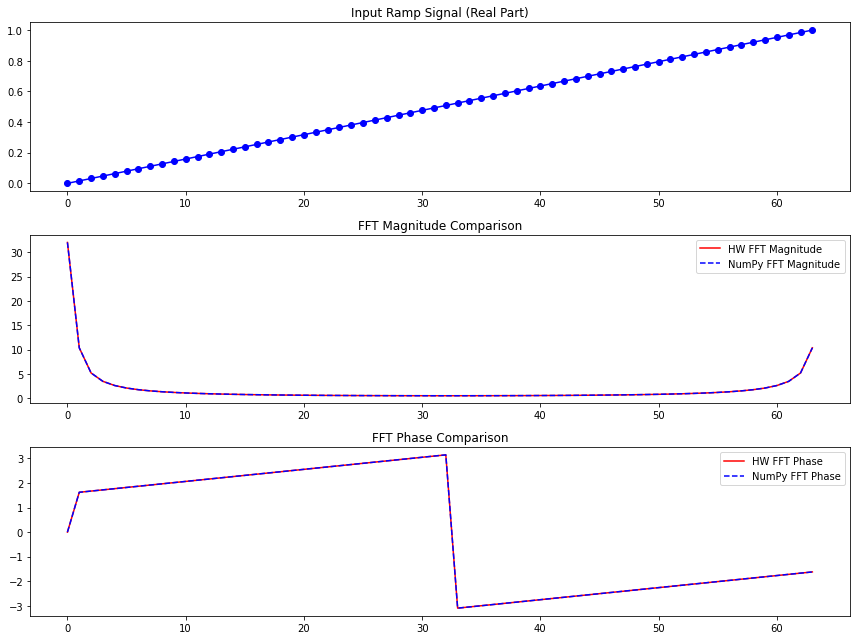

In [22]:
import numpy as np
import time
import mmap
import os
import struct
import matplotlib.pyplot as plt

# Constants from your hardware header (offset base addresses)
AP_CTRL = 0x000
GIE = 0x004
IER = 0x008
ISR = 0x00C

INPUT_BASES = [0x040 + i*0x40 for i in range(8)]
OUTPUT_BASES = [0x240 + i*0x40 for i in range(8)]

N_BANKS = 8
BANK_DEPTH = 8  # samples per bank
SAMPLES = N_BANKS * BANK_DEPTH  # 64 samples total
FIXED_FRAC_BITS = 16  # Q16 fixed-point format

# Memory map size, depends on your IP mapping, adjust if needed
MMAP_SIZE = 0x440

# Device path to your UIO device (adjust if needed)
UIO_DEVICE = "/dev/uio0"

# Open and mmap device memory
uio_fd = os.open(UIO_DEVICE, os.O_RDWR | os.O_SYNC)
mem = mmap.mmap(uio_fd, MMAP_SIZE, mmap.MAP_SHARED, mmap.PROT_READ | mmap.PROT_WRITE, offset=0)

def read_reg(offset):
    mem.seek(offset)
    data = mem.read(4)
    return struct.unpack("<I", data)[0]

def write_reg(offset, value):
    mem.seek(offset)
    mem.write(struct.pack("<I", value))

def float_to_fixed(x):
    val = int(round(x * (1 << FIXED_FRAC_BITS)))
    return val & 0xFFFFFFFF

def fixed_to_float(x):
    # Convert from signed 32-bit fixed Q16 to float
    if x & 0x80000000:
        x = -((~x + 1) & 0xFFFFFFFF)
    return float(x) / (1 << FIXED_FRAC_BITS)

def write_complex_input(samples):
    # samples: numpy complex64 array length 64
    # Write to input banks memory, each sample 64-bit (2x32-bit words)
    for bank in range(N_BANKS):
        base = INPUT_BASES[bank]
        for i in range(BANK_DEPTH):
            idx = bank * BANK_DEPTH + i
            real_fixed = float_to_fixed(samples[idx].real)
            imag_fixed = float_to_fixed(samples[idx].imag)
            write_reg(base + i*8, real_fixed)       # lower 32 bits real
            write_reg(base + i*8 + 4, imag_fixed)   # upper 32 bits imag

def read_complex_output():
    # Read 64 complex samples from output banks
    out = np.zeros(SAMPLES, dtype=np.complex64)
    for bank in range(N_BANKS):
        base = OUTPUT_BASES[bank]
        for i in range(BANK_DEPTH):
            idx = bank * BANK_DEPTH + i
            real_fixed = read_reg(base + i*8)
            imag_fixed = read_reg(base + i*8 + 4)
            out[idx] = complex(fixed_to_float(real_fixed), fixed_to_float(imag_fixed))
    return out

def start_fft():
    ctrl = read_reg(AP_CTRL)
    auto_restart = ctrl & 0x80
    write_reg(AP_CTRL, auto_restart | 0x01)

def is_done():
    ctrl = read_reg(AP_CTRL)
    return ((ctrl >> 1) & 0x1) == 1

def wait_done(timeout=5.0):
    t_start = time.time()
    while not is_done():
        if time.time() - t_start > timeout:
            raise TimeoutError("FFT hardware did not complete in time")
        time.sleep(0.001)

def main():
    # Generate ramp input signal (real ramp 0 to 1, imag=0)
    ramp_real = np.linspace(0, 1, SAMPLES)
    ramp_input = ramp_real + 0j

    # Write ramp signal to FFT input memories
    write_complex_input(ramp_input)

    # Start FFT hardware
    start_fft()

    # Wait for FFT to finish
    wait_done()

    # Read FFT hardware output
    hw_fft = read_complex_output()

    # Reference FFT using numpy
    np_fft = np.fft.fft(ramp_input)

    # Plot results
    x = np.arange(SAMPLES)

    plt.figure(figsize=(12, 9))

    plt.subplot(3, 1, 1)
    plt.plot(x, ramp_real, 'b-o')
    plt.title("Input Ramp Signal (Real Part)")

    plt.subplot(3, 1, 2)
    plt.plot(x, np.abs(hw_fft), 'r-', label="HW FFT Magnitude")
    plt.plot(x, np.abs(np_fft), 'b--', label="NumPy FFT Magnitude")
    plt.title("FFT Magnitude Comparison")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(x, np.angle(hw_fft), 'r-', label="HW FFT Phase")
    plt.plot(x, np.angle(np_fft), 'b--', label="NumPy FFT Phase")
    plt.title("FFT Phase Comparison")
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    try:
        main()
    finally:
        mem.close()
        os.close(uio_fd)


Hardware FFT execution time: 0.077 ms
Software FFT execution time: 0.148 ms


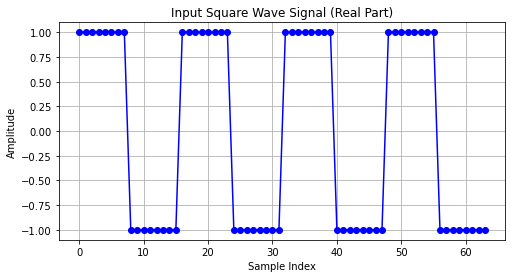

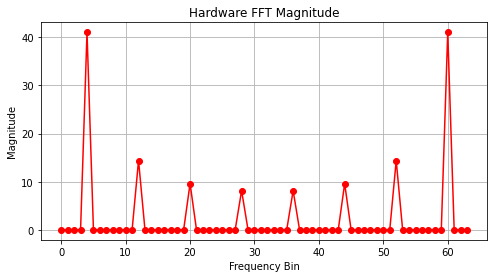

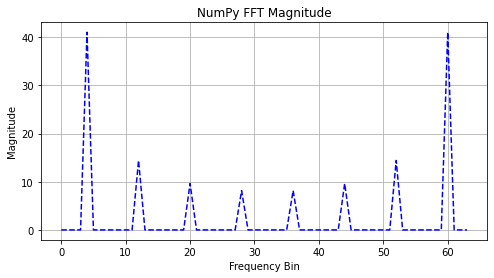

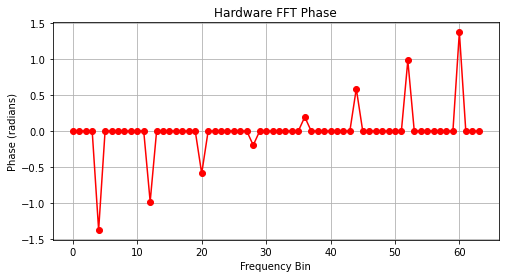

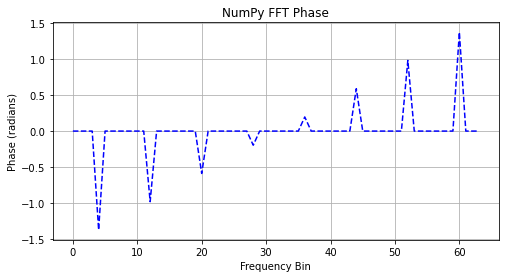

In [23]:
import numpy as np
import time
import mmap
import os
import struct
import matplotlib.pyplot as plt

# Constants from your hardware header (offset base addresses)
AP_CTRL = 0x000
GIE = 0x004
IER = 0x008
ISR = 0x00C

INPUT_BASES = [0x040 + i*0x40 for i in range(8)]
OUTPUT_BASES = [0x240 + i*0x40 for i in range(8)]

N_BANKS = 8
BANK_DEPTH = 8  # samples per bank
SAMPLES = N_BANKS * BANK_DEPTH  # 64 samples total
FIXED_FRAC_BITS = 16  # Q16 fixed-point format

# Memory map size, depends on your IP mapping, adjust if needed
MMAP_SIZE = 0x440

# Device path to your UIO device (adjust if needed)
UIO_DEVICE = "/dev/uio0"

# Open and mmap device memory
uio_fd = os.open(UIO_DEVICE, os.O_RDWR | os.O_SYNC)
mem = mmap.mmap(uio_fd, MMAP_SIZE, mmap.MAP_SHARED, mmap.PROT_READ | mmap.PROT_WRITE, offset=0)

def read_reg(offset):
    mem.seek(offset)
    data = mem.read(4)
    return struct.unpack("<I", data)[0]

def write_reg(offset, value):
    mem.seek(offset)
    mem.write(struct.pack("<I", value))

def float_to_fixed(x):
    val = int(round(x * (1 << FIXED_FRAC_BITS)))
    return val & 0xFFFFFFFF

def fixed_to_float(x):
    # Convert from signed 32-bit fixed Q16 to float
    if x & 0x80000000:
        x = -((~x + 1) & 0xFFFFFFFF)
    return float(x) / (1 << FIXED_FRAC_BITS)

def write_complex_input(samples):
    # samples: numpy complex64 array length 64
    # Write to input banks memory, each sample 64-bit (2x32-bit words)
    for bank in range(N_BANKS):
        base = INPUT_BASES[bank]
        for i in range(BANK_DEPTH):
            idx = bank * BANK_DEPTH + i
            real_fixed = float_to_fixed(samples[idx].real)
            imag_fixed = float_to_fixed(samples[idx].imag)
            write_reg(base + i*8, real_fixed)       # lower 32 bits real
            write_reg(base + i*8 + 4, imag_fixed)   # upper 32 bits imag

def read_complex_output():
    # Read 64 complex samples from output banks
    out = np.zeros(SAMPLES, dtype=np.complex64)
    for bank in range(N_BANKS):
        base = OUTPUT_BASES[bank]
        for i in range(BANK_DEPTH):
            idx = bank * BANK_DEPTH + i
            real_fixed = read_reg(base + i*8)
            imag_fixed = read_reg(base + i*8 + 4)
            out[idx] = complex(fixed_to_float(real_fixed), fixed_to_float(imag_fixed))
    return out

def start_fft():
    ctrl = read_reg(AP_CTRL)
    auto_restart = ctrl & 0x80
    write_reg(AP_CTRL, auto_restart | 0x01)

def is_done():
    ctrl = read_reg(AP_CTRL)
    return ((ctrl >> 1) & 0x1) == 1

def wait_done(timeout=5.0):
    t_start = time.time()
    while not is_done():
        if time.time() - t_start > timeout:
            raise TimeoutError("FFT hardware did not complete in time")
        time.sleep(0.001)



def main():
    # Generate square wave input signal: alternating 1 and -1 in real part, imag=0
    x = np.arange(SAMPLES)
    square_wave_real = np.where((x // (SAMPLES // 8)) % 2 == 0, 1.0, -1.0)  # 8 periods square wave
    square_wave_input = square_wave_real + 0j

    # Write square wave signal to FFT input memories
    write_complex_input(square_wave_input)
    start_time_hw = time.time()
    # Start FFT hardware
    start_fft()

    # Wait for FFT to finish
    wait_done()
    end_time_hw = time.time()
    # Read FFT hardware output
    hw_fft = read_complex_output()
    
    # Reference FFT using numpy
    start_time_sw = time.time()
    np_fft = np.fft.fft(square_wave_input)
    end_time_sw = time.time()
    x = np.arange(SAMPLES)
    print(f"Hardware FFT execution time: {(end_time_hw - start_time_hw)*1000:.3f} ms")
    print(f"Software FFT execution time: {(end_time_sw - start_time_sw)*1000:.3f} ms")
    # Plot 1: Input Square Wave (Real Part)
    plt.figure(figsize=(8, 4))
    plt.plot(x, square_wave_real, 'b-o')
    plt.title("Input Square Wave Signal (Real Part)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Plot 2: Hardware FFT Magnitude
    plt.figure(figsize=(8, 4))
    plt.plot(x, np.abs(hw_fft), 'r-o')
    plt.title("Hardware FFT Magnitude")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Magnitude")
    plt.grid(True)

    # Plot 3: NumPy FFT Magnitude
    plt.figure(figsize=(8, 4))
    plt.plot(x, np.abs(np_fft), 'b--')
    plt.title("NumPy FFT Magnitude")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Magnitude")
    plt.grid(True)

    # Plot 4: Hardware FFT Phase
    plt.figure(figsize=(8, 4))
    plt.plot(x, np.angle(hw_fft), 'r-o')
    plt.title("Hardware FFT Phase")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Phase (radians)")
    plt.grid(True)

    # Plot 5: NumPy FFT Phase
    plt.figure(figsize=(8, 4))
    plt.plot(x, np.angle(np_fft), 'b--')
    plt.title("NumPy FFT Phase")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Phase (radians)")
    plt.grid(True)

    plt.show()


if __name__ == "__main__":
    try:
        main()
    finally:
        mem.close()
        os.close(uio_fd)
